# SpaceNet8 Inference Ensemble

2. flood

clean と 一般データで ensemble が有効か？

## overview
- `data_prep` までは公開ベースラインと同じ
- 推論部分
- open baseline と同じ出力をする

1. metrics
2. threshold distribution
3. optimize threshold
4. fold ensemble
5. test time augmentation
6. debug ping output


## Env
`baseline.ipynb` に従う

## Import

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed
import gc

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box
import matplotlib.pyplot as plt
from matplotlib import colors
import cv2

import tifffile
from osgeo import gdal
from osgeo import osr

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import jaccard_score
from scipy.optimize import minimize
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
from adabelief_pytorch import AdaBelief
import segmentation_models_pytorch as smp
import ttach as tta

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import LightningDataModule, LightningModule

from utils.utils import write_geotiff, TimmUnet

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

## Config

In [2]:
PATH_CFGS = [
    '../../train/output/flood/3090_V5_clean-v3__timmu_IMG1312_hrnet_w18_fl-tr_b4/3090_fold-0/cfg.json',
    '../../train/output/flood/3090_V5__timmu_IMG1312_hrnet_w30_fl-tr/3090_fold-0/cfg.json',
]

cfgs = []

for k, PATH_CFG in enumerate(PATH_CFGS):
    with open(PATH_CFG) as f:
        cfg = json.load(f)

    # box
    cfg = Box(cfg)
    print(f"\n ensemble model {k} cfg::\n")
    pprint(cfg)
    cfgs.append(cfg)


 ensemble model 0 cfg::

{'PATH_FOLD_CSV': '../../data/folds/',
 'augmentation': "{'train':Compose([Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}",
 'csv_state': 'clean-v3_',
 'debug': False,
 'debug_sample': 32,
 'epoch': 200,
 'eps': 1e-12,
 'f': 'flood',
 'features': BoxList(['preimg', 'postimg', 'building', 'road', 'roadspeed', 'flood']),
 'fold': 0,
 'folds': 5,
 'group': '3090_V5_clean-v3__timmu_IMG1312_hrnet_w18_fl-tr_b4',
 'mixup': 0.0,
 'model': {'act': None,
           'architecture': 'timmu',
           'decoder_channels': BoxList([256, 128, 64, 32, 16

In [3]:
# UPDATE
for k, cfg in enumerate(cfgs):
    cfgs[k].model.threshold = 0.3
    cfgs[k]['val_loader'] = {'batch_size': 1,
                    'drop_last': False,
                    'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': False}

# 1 fold
HANSFOLD = False


# 乱数のシードを設定
seed_everything(cfgs[0].seed)
torch.manual_seed(cfgs[0].seed)
np.random.seed(cfgs[0].seed)
random.seed(cfgs[0].seed)

Global seed set to 417


## Augmentation

In [4]:
# augmentation
tf_dict = {
    'val': A.Compose(
        [
            A.Resize(cfgs[0].preprocess.input_size, cfgs[0].preprocess.input_size,
                    interpolation=1),
            ToTensorV2(),
        ]
    ),
} 

tf_dict['test'] = tf_dict['val']

## Dataset

In [5]:
class SpaceNnet8Dataset(Dataset):
    def __init__(self,
                 fold: int,
                 phase: str,
                 ):
        """ pytorch dataset for spacenet-8 data. loads images from a csv that contains filepaths to the images
        
        Parameters:
        ------------
        fold: (int) 
            preimg column contains filepaths to the pre-event image tiles (.tif)
            postimg column contains filepaths to the post-event image tiles (.tif)
            building column contains the filepaths to the binary building labels (.tif)
            road column contains the filepaths to the binary road labels (.tif)
            roadspeed column contains the filepaths to the road speed labels (.tif)
            flood column contains the filepaths to the flood labels (.tif)
        data_to_load (list): a list that defines which of the images and labels to load from the .csv. 
        
        """
        
        self.phase = phase
        
        if phase == 'test':
            self.all_data_types = ["preimg", "postimg"]
            csv_filename = os.path.join('../../data/Louisiana-West_Test_Public/', 'test_preimg-postimg.csv')
        else:
            self.all_data_types = ["preimg", "postimg", "building", "road", "roadspeed", "flood"]
            csv_filename = os.path.join(cfg.PATH_FOLD_CSV, f'fold{fold}_seed{cfg.seed}_{self.phase}.csv')
        
        self.data_to_load = self.all_data_types
        
        self.transform = tf_dict[self.phase]
        
        self.files = []

        dict_template = {}
        for i in self.all_data_types:
            dict_template[i] = None
        
        with open(csv_filename, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for k, row in enumerate(reader):
                in_data = copy.copy(dict_template)
                for j in self.data_to_load:
                    in_data[j]=row[j]
                self.files.append(in_data)
                
                if cfg.debug and k > cfg.debug_sample:
                    break
        
        print("loaded", len(self.files), "image filepaths")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        data_dict = self.files[index]

        imgs, masks = [], []
        
        # gather
        for i in self.all_data_types:
            filepath = data_dict[i]
            if filepath is not None:
                # need to resample postimg to same spatial resolution/extent as preimg and labels.
                if i == "postimg":
                    ds = self.get_warped_ds(data_dict["postimg"])
                else:
                    ds = gdal.Open(filepath)
                image = ds.ReadAsArray()
                ds = None
            
                if i in ['preimg' ,'postimg']:
                    imgs.append(image.transpose(1, 2, 0))
                else:
                    # 1 channel
                    if len(image.shape) <= 2:
                        masks.append(image[:,:, np.newaxis])
                    else:
                        masks.append(image.transpose(1, 2, 0))
        
        # align channel last
        imgs = np.concatenate(imgs, axis=2)
        
        if self.phase != 'test':
            masks = np.concatenate(masks, axis=2)
        
        # augmentation
        if self.phase == 'test':
            transformed = self.transform(image=imgs)
        else:
            transformed = self.transform(image=imgs, mask=masks)
        
        imgs = transformed["image"]
        
        if self.phase != 'test':
            masks = transformed["mask"].permute(2, 0, 1) # torch channel fast
        
        return imgs, masks

    def get_image_filename(self, index: int) -> str:
        """ return pre-event image absolute filepath at index """
        data_dict = self.files[index]
        return data_dict["preimg"]

    def get_warped_ds(self, post_image_filename: str) -> gdal.Dataset:
        """ gdal warps (resamples) the post-event image to the same spatial resolution as the pre-event image and masks 
        
        SN8 labels are created from referencing pre-event image. Spatial resolution of the post-event image does not match the spatial resolution of the pre-event imagery and therefore the labels.
        In order to align the post-event image with the pre-event image and mask labels, we must resample the post-event image to the resolution of the pre-event image. Also need to make sure
        the post-event image covers the exact same spatial extent as the pre-event image. this is taken care of in the the tiling"""
        ds = gdal.Warp("", post_image_filename,
                       format='MEM', width=1300, height=1300,
                       resampleAlg=gdal.GRIORA_Bilinear,
                       outputType=gdal.GDT_Byte)
        return ds

## Model

In [6]:
class SpaceNet8Model(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        # self._criterion = eval(cfg.model.loss)
        
    def __build_model(self):
        if self.cfg.model.architecture == 'smp':
            self.backbone = smp.UnetPlusPlus(encoder_name=cfg.model.encoder_name,
                                                encoder_weights="imagenet",
                                        decoder_attention_type='scse',
                                        in_channels=cfg.model.in_channels, activation=cfg.model.act,
                                        decoder_channels=cfg.model.decoder_channels,
                                        classes=cfg.model.out_channels)
        elif self.cfg.model.architecture == 'unet':
            self.backbone = smp.Unet(
                in_channels=cfg.model.in_channels, 
                classes=cfg.model.out_channels, 
                **cfg.model.unet_params)
        elif self.cfg.model.architecture == 'timmu':
            self.backbone = TimmUnet(
                in_chans=cfg.model.in_channels,
                out_chans=cfg.model.out_channels,
                pretrained=True,
                channels_last=False,
                **self.cfg.model.timmu.encoder_params,
                )
            
        else:
            raise ValueError(f'Check `cfg.model.architecture` >>> {self.model.architecture}')

    def forward(self, x):
        feat = self.backbone(x)
        return feat

## Inference

In [7]:
# check fold 0 model
fold = 0
dirpath = f'{cfgs[0].outdir}{cfgs[0].group}/{cfgs[0].runname}_fold-{fold}/'
filename = f"best_fold-{fold}"
PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

save_preds_dir = f'{dirpath}fld/'
save_fig_dir = f'{dirpath}png/'
os.makedirs(save_preds_dir, exist_ok=True)
os.makedirs(save_fig_dir, exist_ok=True)

# exist check
!ls {PATH_BEST_MODEL}

../../train/output/flood/3090_V5_clean-v3__timmu_IMG1312_hrnet_w18_fl-tr_b4/3090_fold-0/best_fold-0.ckpt


In [8]:
# load check
model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfgs[0])
model.eval()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if cfg.debug:
    device = torch.device('cpu')

model = model.to(device)
print(f'{device=}')

device=device(type='cuda', index=0)


In [9]:
def make_prediction_flood_png(image, postimage, gt, prediction, save_figure_filename):
    raw_im = image.transpose(1, 2, 0) # now it is channels last
    raw_im = raw_im/np.max(raw_im)
    post_im = postimage.transpose(1, 2, 0)
    post_im = post_im/np.max(post_im)
    
    combined_mask_cmap = colors.ListedColormap(['black', 'red', 'blue', 'green', 'yellow'])

    grid = [[raw_im, gt, prediction],[post_im, 0, 0]]

    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    for row in range(2):
        for col in range(3):
            ax = axs[row][col]
            ax.axis('off')
            if row==0 and col == 0:
                theim = ax.imshow(grid[row][col])
            elif row==1 and col == 0:
                theim = ax.imshow(grid[row][col])
            elif row==0 and col in [1,2]:
                ax.imshow(grid[row][col],
                          interpolation='nearest', origin='upper',
                          cmap=combined_mask_cmap,
                          norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
            elif row==1 and col == 1:
                ax.imshow(grid[0][0])
                mask = np.where(gt==0, np.nan, 1)
                ax.imshow(mask, cmap='gist_rainbow_r', alpha=0.6)
            elif row==1 and col == 2:
                ax.imshow(grid[0][0])
                mask = np.where(prediction==0, np.nan, 1)
                ax.imshow(mask, cmap='gist_rainbow_r', alpha=0.6)

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(save_figure_filename, dpi=95)
    if cfg.debug:
        plt.show();
    plt.clf()
    plt.close(fig)
    plt.close('all')


## Eval

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
thresholds = []

for fold in range(cfg.folds):
    
    models = []
    
    # ensemble
    for cfg in cfgs:
        
        # fold setting
        dirpath = f'{cfg.outdir}{cfg.group}/{cfg.runname}_fold-{fold}/'
        filename = f"best_fold-{fold}"
        PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

        save_preds_dir = f'{dirpath}ensemble/fld/'
        save_fig_dir = f'{dirpath}ensemble/png/'
        
        # model
        model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfg)
        model.eval()
        if cfg.debug:
            device = torch.device('cpu')

        model = model.to(device)
        print(f'{device=}')
        
        # TTA
        model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
        models.append(model)
    
    print("SAVE PATH:", save_preds_dir, save_fig_dir)
    os.makedirs(save_preds_dir, exist_ok=True)
    os.makedirs(save_fig_dir, exist_ok=True)
    
    # metrics
    df = pd.DataFrame({
        'filename': [], 'channel': [],
        'tp': [] , 'fp': [], 'fn': [],
        'union': [], 'precision': [], 'recall': [],
        'f1': [], 'iou': [],
    })
    
    ds_val = SpaceNnet8Dataset(fold, phase='val')
    dl_val = DataLoader(ds_val, **cfg.val_loader)
    
    classes = ["non-flooded building", "flooded building", "non-flooded road", "flooded road"]
    running_tp = [0, 0, 0, 0]
    running_fp = [0, 0, 0, 0]
    running_fn = [0, 0, 0, 0]
    running_union = [0, 0, 0, 0]
    running_iou = [0,0,0,0]
    filenames = []
    precisions = [[],[],[],[]]
    recalls = [[],[],[],[]]
    f1s = [[],[],[],[]]
    ious = [[],[],[],[]]
    positives = [[],[],[],[]]
    count = 0
    
    print(f'#'*60)
    print(f'### Fold: {fold} HANSFOLD: {HANSFOLD} NUM ENSEMBLE: {len(cfgs)}')
    print(f'#'*60)
    print(f'### Start Inference')


    for i, (images, labels) in enumerate(dl_val):
        current_image_filename = ds_val.get_image_filename(i)
        print("evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(current_image_filename))
        # print(images.shape, labels.shape)
        
        # cuda
        images = images.to(device)
        images = images.float()
        
        outputs = torch.zeros((1, 4, cfgs[0].preprocess.input_size,cfgs[0].preprocess.input_size)).to(device)
        
        with torch.no_grad():
            for model in models:
                outputs += model(images)
                
        outputs = torch.sigmoid(outputs / len(cfgs))
        outputs = outputs.cpu().numpy()
        images = images.cpu().numpy()
        
        # allocate
        preimg, postimg = images[0, :3, :, :], images[0, 3:, :, :]
        build, road, speed, flood = \
            labels[0, 0, :, :], labels[0, 1, :, :], labels[0, 1:9, :, :], labels[0, 10:14, :, :]
        pred_flood = outputs[0, :4, :, :]
        
        # mask
        premask = 1. - (np.mean(preimg, 0) == np.zeros(build.shape)).astype(np.float32)
        postmask = 1. - (np.mean(postimg, 0) == np.zeros(build.shape)).astype(np.float32)
        mask = premask * postmask
        _pred_flood = pred_flood * np.stack([mask]*4)
        
        best_ths = []
        for c in range(4):
            # optimize threshold
            def _opt(x):
                return -jaccard_score(flood[c], _pred_flood[c] >= x, average='micro') 
            
            result = minimize(_opt, x0=np.array([0.45]), method='Powell', tol=1e-2)
            best_th = result['x'].item()
            best_ths.append(best_th)
        thresholds.append(best_ths)   
        
        # variable threshold
        for vt_w in range(4):
            pred_flood = np.where(_pred_flood > cfg.model.threshold - (0.5 * vt_w), _pred_flood, 0.)
            # casting and background
            pred_flood = np.concatenate([np.zeros((1, *pred_flood.shape[1:])) + 0.01, pred_flood], axis=0) # backgroug+
            pred_flood = np.argmax(pred_flood, axis=0) # 5 channnel -> 1 channel
            
            if np.count_nonzero(pred_flood) > 0:
                # 全面推論抑制
                if np.count_nonzero(pred_flood) > pred_flood.size * 0.5:
                    pred_flood = np.zeros(pred_flood.shape, dtype=np.uint8)
                    break
                else:
                    # 最適閾値
                    break 
        
        flood = np.where(flood > cfg.model.threshold, flood, 0.)
        # casting and background
        flood = np.concatenate([np.zeros((1, *flood.shape[1:])) + 0.01, flood], axis=0) # background+
        flood = np.argmax(flood, axis=0) # 5 channnel -> 1 channel
        
        ### save prediction
        if save_preds_dir is not None:
            ds = gdal.Open(current_image_filename)
            geotran = ds.GetGeoTransform()
            xmin, xres, rowrot, ymax, colrot, yres = geotran
            raster_srs = osr.SpatialReference()
            raster_srs.ImportFromWkt(ds.GetProjectionRef())
            ds = None
            output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_floodpred.tif")))
            nrows, ncols = pred_flood.shape
            write_geotiff(output_tif, ncols, nrows,
                        xmin, xres, ymax, yres,
                        raster_srs, [pred_flood])
        
        
        for j in range(4): # there are 4 classes
            gt = np.where(flood==(j+1), 1, 0)
            prediction = np.where(pred_flood==(j+1), 1, 0)

            tp = np.rint(prediction * gt)
            fp = np.rint(prediction - tp)
            fn = np.rint(gt - tp)
            union = np.rint(np.sum(prediction + gt - tp))

            iou = np.sum(tp) / np.sum((prediction + gt - tp + 0.00001))
            tp = np.sum(tp).astype(int)
            fp = np.sum(fp).astype(int)
            fn = np.sum(fn).astype(int)

            running_tp[j]+=tp
            running_fp[j]+=fp
            running_fn[j]+=fn
            running_union[j]+=union
            running_iou[j]+=iou

            #acc = np.sum(np.where(prediction == gt, 1, 0)) / (gt.shape[0] * gt.shape[1])
            precision = tp / (tp + fp + 0.00001)
            recall = tp / (tp + fn + 0.00001)
            f1 = 2 * (precision * recall) / (precision + recall + 0.00001)
            precisions[j].append(precision)
            recalls[j].append(recall)
            f1s[j].append(f1)
            ious[j].append(iou)
            
            df.loc[count] = [ 
                current_image_filename,
                classes[j],
                tp , fp, fn,
                union, precision, recall,
                f1, iou,
            ]
            
            count += 1

            if np.sum(gt) < 1:
                positives[j].append("n")
            else:
                positives[j].append("y")
            
        current_image_filename = ds_val.files[i]["preimg"]
        filenames.append(current_image_filename)
        if save_fig_dir != None:
            save_figure_filename = os.path.join(save_fig_dir, os.path.basename(current_image_filename)[:-4]+"_pred.png")
            make_prediction_flood_png(preimg, postimg, flood[1:], pred_flood[1:], save_figure_filename)
            
        # early exit
        if cfg.debug and i > 2:
            break
    
    # foldout metrics
    print()
    for j in range(len(classes)):
        print(f"class: {classes[j]}")
        df[f'{classes[j]}_mean_tp'] = running_tp[j]
        df[f'{classes[j]}_mean_fp'] = running_fp[j]
        df[f'{classes[j]}_mean_fn'] = running_fn[j]
        precision = running_tp[j] / (running_tp[j] + running_fp[j] + 0.00001)
        recall = running_tp[j] / (running_tp[j] + running_fn[j] + 0.00001)
        f1 = 2 * (precision * recall) / (precision + recall + 0.00001)
        iou = running_tp[j] / (running_union[j] + 0.00001)
        print("  precision: ", precision)
        df[f'{classes[j]}_mean_precision'] = precision
        print("  recall: ", recall)
        df[f'{classes[j]}_mean_recall'] = recall
        print("  f1: ", f1)
        df[f'{classes[j]}_mean_f1'] = f1
        print("  iou: ", iou)
        df[f'{classes[j]}_mean_iou'] = iou        

    df.to_csv(f'{dirpath}oof_fold{fold}_threshold{cfg.model.threshold}.csv', index=False, header=True)
    
    if HANSFOLD:
        break
    
    # fold
    # break

device=device(type='cuda', index=0)
device=device(type='cuda', index=0)
SAVE PATH: ../../train/output/flood/3090_V5__timmu_IMG1312_hrnet_w30_fl-tr/3090_fold-0/ensemble/fld/ ../../train/output/flood/3090_V5__timmu_IMG1312_hrnet_w30_fl-tr/3090_fold-0/ensemble/png/
loaded 161 image filepaths
############################################################
### Fold: 0 HANSFOLD: False NUM ENSEMBLE: 2
############################################################
### Start Inference
evaluating:  0/161 10500500C4DD7000_0_23_70.tif
evaluating:  1/161 10500500C4DD7000_0_35_59.tif
evaluating:  2/161 10500500C4DD7000_0_32_56.tif
evaluating:  3/161 10500500C4DD7000_0_22_69.tif
evaluating:  4/161 10500500C4DD7000_0_16_70.tif
evaluating:  5/161 10500500C4DD7000_0_23_68.tif
evaluating:  6/161 10500500C4DD7000_0_25_62.tif
evaluating:  7/161 10500500C4DD7000_0_44_68.tif
evaluating:  8/161 10500500C4DD7000_0_19_67.tif
evaluating:  9/161 10500500C4DD7000_0_42_61.tif
evaluating:  10/161 10500500C4DD7000_0_41_58

In [11]:
thresholds = np.array(thresholds)

df_thresh = pd.DataFrame()
for i in range(4):
    df_thresh[classes[i]] = thresholds[:, i]

df_thresh['idx'] = np.arange(len(df_thresh))

df_thresh.head()

,non-flooded building,flooded building,non-flooded road,flooded road,idx
0,0.058457,1.45,0.374058,1.45,0
1,0.094484,1.45,0.408352,1.45,1
2,1.450000,1.45,1.450000,1.45,2
3,0.438200,1.45,0.053829,1.45,3
4,1.450000,1.45,0.289457,1.45,4


threshold mean: 0.8168487314539142


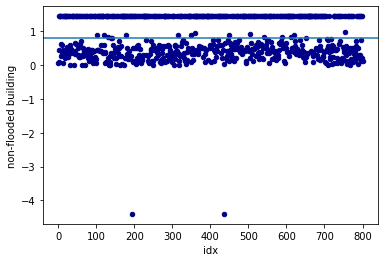

thresh hold mean: 0.386811240117136


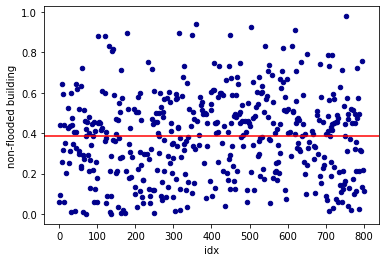

threshold mean: 1.2449864946159337


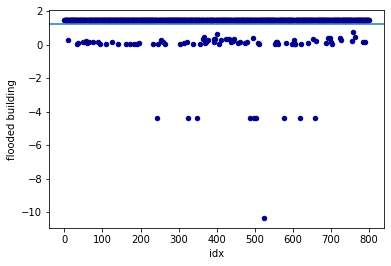

thresh hold mean: 0.1712693316216278


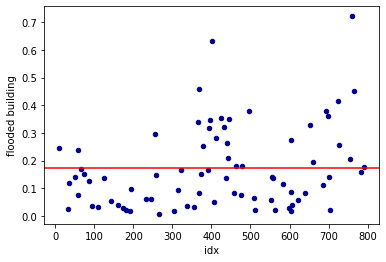

threshold mean: 0.5414954257550002


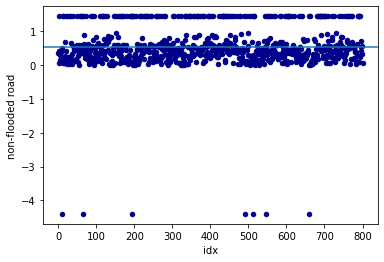

thresh hold mean: 0.3786529641649847


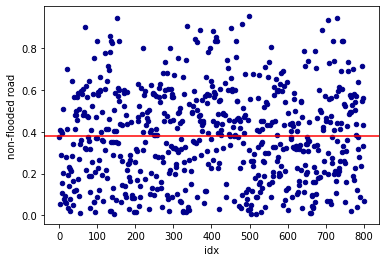

threshold mean: 1.2041395655504592


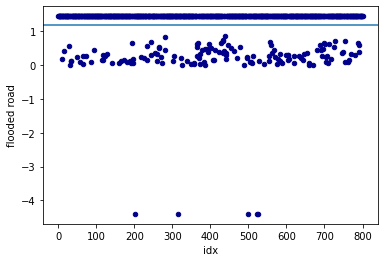

thresh hold mean: 0.3016185068898503


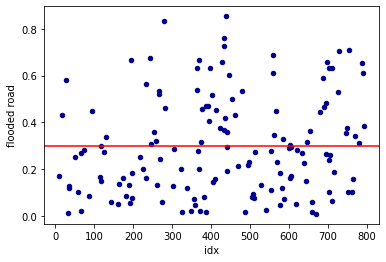

In [12]:
for i, col in enumerate(classes):
    df_thresh.plot.scatter(x='idx', y=col, c='DarkBlue')
    mean_th = df_thresh[col].values.mean()
    print(f'threshold mean: {mean_th}')
    plt.axhline(y=mean_th, xmin=0, xmax=len(df_thresh))
    plt.savefig(f'{cfg.outdir}{cfg.group}/{classes[i]}_threshold_all_fold{fold}.png')
    plt.show();

    # 適切な閾値のみ
    bet_th = df_thresh[(df_thresh[col] < 1.0) & (df_thresh[col] > 0.)]
    mean_th = bet_th[col].values.mean()
    print(f'thresh hold mean: {mean_th}')

    bet_th.plot.scatter(x='idx', y=col, c='DarkBlue')
    plt.axhline(y=mean_th, xmin=0, xmax=len(bet_th), color='r')
    plt.savefig(f'{cfg.outdir}{cfg.group}/{classes[i]}_threshold_better_fold{fold}.png')
    plt.show();

## Test

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device=}')
fold = cfg.folds -1

print(f'#'*60)
print(f'### Fold: {fold} HANSFOLD: {HANSFOLD} NUM ENSEMBLE: {len(cfgs)}')
print(f'#'*60)
print(f'### Start Inference')

ds_val = SpaceNnet8Dataset(fold, phase='test')
dl_val = DataLoader(ds_val, **cfg.val_loader)

for i, (images, _) in enumerate(dl_val):
    current_image_filename = ds_val.get_image_filename(i)
    print("evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(current_image_filename))
    # print(images.shape, labels.shape)
    
    # cuda
    images = images.to(device)
    images = images.float()
    outputs = torch.zeros((1, 4, cfg.preprocess.input_size,cfg.preprocess.input_size)).to(device)
    
    for fold in range(cfg.folds):
        
        for cfg in cfgs:
        
            # fold setting
            dirpath = f'{cfg.outdir}{cfg.group}/{cfg.runname}_fold-{fold}/'
            filename = f"best_fold-{fold}"
            PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

            save_preds_dir = f'{dirpath}ensemble/test_fld/'
            save_fig_dir = f'{dirpath}ensemble/test_png/'
            
            # model
            model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfg)
            model.eval()
            if cfg.debug:
                device = torch.device('cpu')

            model = model.to(device)
            # TTA
            model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

            with torch.no_grad():
                outputs += model(images)
                
                if HANSFOLD:
                    break
    
    os.makedirs(save_preds_dir, exist_ok=True)
    os.makedirs(save_fig_dir, exist_ok=True)
    # mean average and logits
    if HANSFOLD:
        outputs = torch.sigmoid(outputs / len(cfgs))
    else:
        outputs = torch.sigmoid(outputs/ cfg.folds / len(cfgs)) 
            
    outputs = outputs.cpu().numpy()
    images = images.cpu().numpy()
    
    # allocate
    preimg, postimg = images[0, :3, :, :], images[0, 3:, :, :]
    pred_flood = outputs[0, :4, :, :]
    
    # mask
    premask = 1. - (np.mean(preimg, 0) == np.ones((cfg.preprocess.input_size,cfg.preprocess.input_size))).astype(np.float32)
    postmask = 1. - (np.mean(postimg, 0) == np.ones((cfg.preprocess.input_size,cfg.preprocess.input_size))).astype(np.float32)
    mask = premask * postmask
    _pred_flood = pred_flood * np.stack([mask]*4)
    
    # variable threshold
    for vt_w in range(4):
        pred_flood = np.where(_pred_flood > cfg.model.threshold - (0.5 * vt_w), _pred_flood, 0.)
        # casting and background
        pred_flood = np.concatenate([np.zeros((1, *pred_flood.shape[1:])) + 0.01, pred_flood], axis=0) # background+
        pred_flood = np.argmax(pred_flood, axis=0) # 5 channnel -> 1 channel
        
        if np.count_nonzero(pred_flood) > 0:
            # 全面推論抑制
            if np.count_nonzero(pred_flood) > pred_flood.size * 0.75:
                pred_flood = np.zeros(pred_flood.shape, dtype=np.uint8)
                break
            else:
                # 最適閾値
                break 
    
    # resize
    _pre_img = tifffile.imread(current_image_filename)
    _, _w, _h = _pre_img.shape

    pred_flood = cv2.resize(
        pred_flood[..., np.newaxis].astype(np.float32), 
        dsize=(_h, _w),
        interpolation=cv2.INTER_NEAREST
        )
    
    ### save prediction
    if save_preds_dir is not None:
        ds = gdal.Open(current_image_filename)
        geotran = ds.GetGeoTransform()
        xmin, xres, rowrot, ymax, colrot, yres = geotran
        raster_srs = osr.SpatialReference()
        raster_srs.ImportFromWkt(ds.GetProjectionRef())
        ds = None
        output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_floodpred.tif")))
        nrows, ncols = pred_flood.shape
        write_geotiff(output_tif, ncols, nrows,
                    xmin, xres, ymax, yres,
                    raster_srs, [pred_flood])
    

    flood_dummy = np.zeros(pred_flood.shape)
    
    if save_fig_dir != None:
        save_figure_filename = os.path.join(save_fig_dir, os.path.basename(current_image_filename)[:-4]+"_pred.png")
        make_prediction_flood_png(preimg, postimg, flood_dummy, pred_flood[1:], save_figure_filename)
        
    torch.cuda.empty_cache()
    gc.collect()
        
    # early exit
    if cfg.debug and i > 2:
        break

device=device(type='cuda', index=0)
############################################################
### Fold: 4 HANSFOLD: False NUM ENSEMBLE: 2
############################################################
### Start Inference
loaded 488 image filepaths
evaluating:  0/488 104001006504F400_0_35_12.tif
evaluating:  1/488 104001006504F400_0_20_36.tif
evaluating:  2/488 104001006504F400_0_20_36.tif
evaluating:  3/488 104001006504F400_0_13_26.tif
evaluating:  4/488 104001006504F400_0_13_22.tif
evaluating:  5/488 104001006504F400_0_17_17.tif
evaluating:  6/488 104001006504F400_0_31_23.tif
evaluating:  7/488 104001006504F400_0_3_36.tif
evaluating:  8/488 104001006504F400_0_14_33.tif
evaluating:  9/488 104001006504F400_0_0_16.tif
evaluating:  10/488 104001006504F400_0_19_16.tif
evaluating:  11/488 104001006504F400_0_17_13.tif
evaluating:  12/488 104001006504F400_0_3_19.tif
evaluating:  13/488 104001006504F400_0_10_21.tif
evaluating:  14/488 104001006504F400_0_38_10.tif
evaluating:  15/488 104001006